# Cálculo de la frecuencia cardica a partir de el método statHRMAlgo

Este notebook se basa en el funcionamiento del método **statHRMAlgo(unsigned long ppgData)** dentro de la clase hr_algo del firmware de la incubadora, que es el que se encarga de calcular la frecuencia cardíaca a partir de los datos del sensor. Funcionamiento:

- Acumulación de datos

Se mantiene un promedio móvil (movingWindowHP) con los datos de PPG (ppgData).\
Cada vez que se alcanza un número de muestras (movingWindowSize), se resetea el contador y se actualiza un buffer (peakWindowHP).

- Detección de picos

Se busca un máximo local en una ventana de 20 muestras (peakWindowHP).\
    Si se detecta un pico, se actualiza el valor del último pico (lastPeakValueLED1).
    Si se han detectado más de dos picos, se actualiza el cálculo de la frecuencia cardíaca (updateHeartRate).
    
- Detección de mínimos

Se busca un mínimo local en la misma ventana de 20 muestras.\
Si se encuentra, se guarda el valor (lastOnsetValueLED1).

- Cálculo de la frecuencia cardíaca

Se calcula la frecuencia cardíaca con chooseRate(HR), promediando los valores detectados.\
Se eliminan valores extremos y se promedia el resto.

- Almacenamiento y actualización de valores

Se mantiene un buffer de valores de HR y se actualiza con updateHeartRate.

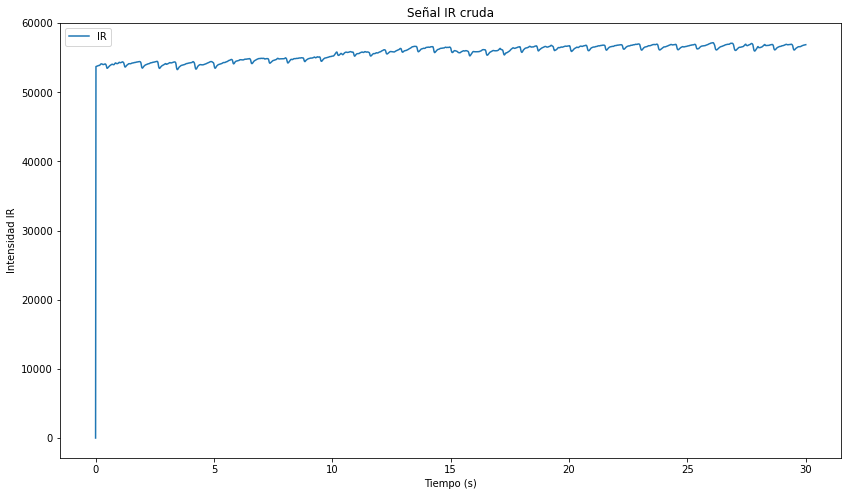

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, decimal='.', engine='python')
df.columns = ["Tiempo", "IR", "AMB_IR", "RED", "AMB_RED"]

# Convertir tiempo a segundos
df["Tiempo"] /= 1000

# Graficar señal IR
plt.figure(figsize=(14, 8))
plt.plot(df["Tiempo"], df["IR"], label='IR')
plt.xlabel("Tiempo (s)")
plt.ylabel("Intensidad IR")
plt.title("Señal IR cruda")
plt.legend()
plt.show()

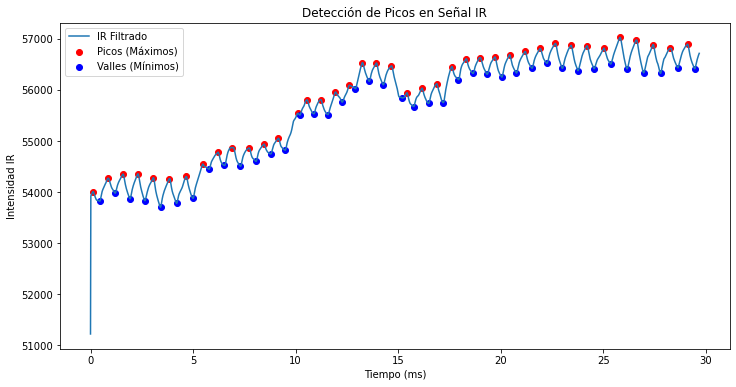

Frecuencia cardíaca estimada (BPM): [ 81743.86920981  81967.21311475  83798.88268156  80000.
  76628.35249042  73529.41176471  73529.41176471  80106.80907877
  92307.69230769  69284.06466513  83798.88268156  85714.28571429
  63157.89473684 133630.28953229  90090.09009009  83682.0083682
  87976.53958944  94786.72985782  87847.73060029  81855.3888131
  80106.80907877  81743.86920981  83798.88268156  80106.80907877
  85836.90987124  89955.02248876  81855.3888131   83798.88268156
  78328.98172324  83798.88268156  80000.          78328.98172324
  76628.35249042  73529.41176471  76628.35249042  75093.86733417
  73529.41176471  72028.81152461  70588.23529412]


In [38]:
# Extraer las columnas necesarias
tiempo = df["Tiempo"].values
ir_signal = df["IR"].values

# Parámetros para la media móvil y detección de picos
ventana_tamaño = 20
threshold_pico = 50000  # Ajustar según el rango de valores de la señal

# Aplicar media móvil
ir_filtrado = np.convolve(ir_signal, np.ones(ventana_tamaño)/ventana_tamaño, mode='valid')

# Detectar picos locales (máximos y mínimos)
picos, _ = find_peaks(ir_filtrado, height=threshold_pico, distance=20)
vales, _ = find_peaks(-ir_filtrado, distance=20)

# Calcular periodos entre picos consecutivos
if len(picos) > 1:
    periodos = np.diff(tiempo[picos]) / 1000  # Convertir a segundos
    frecuencia_cardiaca = 60 / periodos  # Calcular en BPM
else:
    frecuencia_cardiaca = []

# Graficar señal con picos detectados
plt.figure(figsize=(12, 6))
plt.plot(tiempo[:len(ir_filtrado)], ir_filtrado, label='IR Filtrado')
plt.scatter(tiempo[picos], ir_filtrado[picos], color='red', label='Picos (Máximos)')
plt.scatter(tiempo[vales], ir_filtrado[vales], color='blue', label='Valles (Mínimos)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Intensidad IR')
plt.title('Detección de Picos en Señal IR')
plt.legend()
plt.show()

# Mostrar frecuencia cardíaca estimada
print("Frecuencia cardíaca estimada (BPM):", frecuencia_cardiaca)


In [34]:
len(frecuencia_cardiaca)

39

In [35]:
frecuencia_cardiaca

array([ 81743.86920981,  81967.21311475,  83798.88268156,  80000.        ,
        76628.35249042,  73529.41176471,  73529.41176471,  80106.80907877,
        92307.69230769,  69284.06466513,  83798.88268156,  85714.28571429,
        63157.89473684, 133630.28953229,  90090.09009009,  83682.0083682 ,
        87976.53958944,  94786.72985782,  87847.73060029,  81855.3888131 ,
        80106.80907877,  81743.86920981,  83798.88268156,  80106.80907877,
        85836.90987124,  89955.02248876,  81855.3888131 ,  83798.88268156,
        78328.98172324,  83798.88268156,  80000.        ,  78328.98172324,
        76628.35249042,  73529.41176471,  76628.35249042,  75093.86733417,
        73529.41176471,  72028.81152461,  70588.23529412])

El valor obtenido es un conjunto de frecuencias cardíacas estimadas (en BPM, o latidos por minuto), calculadas a partir de los periodos entre los picos de la señal IR detectados. Cada valor corresponde a una frecuencia cardíaca estimada para un intervalo entre dos picos consecutivos.

Por ejemplo, el primer valor es 81,743.87 BPM, lo que significa que entre el primer y segundo pico, la frecuencia cardíaca estimada es esa. Luego, para el siguiente intervalo, se obtiene un valor de 81,967.21 BPM, y así sucesivamente.


La razón por la cual los valores son tan altos podría deberse a varias razones:

- Detección incorrecta de picos: Si los picos no son detectados correctamente o si se detectan en lugares donde no deberían, los cálculos de periodos serán incorrectos. Esto puede llevar a frecuencias cardíacas inusualmente altas.

- Valores atípicos o ruido en los datos: Si la señal IR tiene mucho ruido o picos falsos, esos picos pueden generar periodos muy pequeños, lo que da lugar a una frecuencia cardíaca extremadamente alta.

- Filtrado insuficiente: El método de media móvil que aplicamos puede no estar eliminando suficiente ruido o no estar ajustado de forma óptima para los datos específicos del pulsioxímetro que estás utilizando.

In [40]:
# Convertir cada valor de la frecuencia cardíaca a formato con solo dos unidades y decimales
frecuencia_convertida = [f"{int(valor/1000)},{int((valor % 1000) / 10):02}" for valor in frecuencia_cardiaca]

# Convertir la lista de strings con coma a float reemplazando la coma por el punto
frecuencia_convertida_float = [float(valor.replace(',', '.')) for valor in frecuencia_convertida]

# Mostrar los valores convertidos
print("Frecuencia cardíaca convertida (BPM):", frecuencia_convertida_float)


Frecuencia cardíaca convertida (BPM): [81.74, 81.96, 83.79, 80.0, 76.62, 73.52, 73.52, 80.1, 92.3, 69.28, 83.79, 85.71, 63.15, 133.63, 90.09, 83.68, 87.97, 94.78, 87.84, 81.85, 80.1, 81.74, 83.79, 80.1, 85.83, 89.95, 81.85, 83.79, 78.32, 83.79, 80.0, 78.32, 76.62, 73.52, 76.62, 75.09, 73.52, 72.02, 70.58]
Frecuencia cardíaca media (BPM): 81.82


In [ ]:

# Calcular la media de las frecuencias convertidas (en formato decimal)
media_frecuencia_convertida = np.mean(frecuencia_convertida_float)

# Mostrar la media de la frecuencia cardíaca
print("Frecuencia cardíaca media (BPM):", round(media_frecuencia_convertida, 2))

In [45]:
import os

nombre_archivo = os.path.basename(file_path)
frecuencia_cardiaca_real = int(nombre_archivo.split('_')[3])

# Calcular la media de la frecuencia cardíaca estimada
frecuencia_media_estimada = np.mean(media_frecuencia_convertida)

# Calcular el error en la estimación (porcentaje de error)
error_estimacion = (frecuencia_media_estimada - frecuencia_cardiaca_real) / frecuencia_cardiaca_real * 100

# Mostrar los resultados
print(f"Frecuencia cardíaca real (BPM): {frecuencia_cardiaca_real}")
print(f"Frecuencia cardíaca estimada media (BPM): {round(frecuencia_media_estimada, 2)}")
print(f"Error en la estimación de la frecuencia cardíaca: {round(error_estimacion, 2)}%")

Frecuencia cardíaca real (BPM): 77
Frecuencia cardíaca estimada media (BPM): 81.82
Error en la estimación de la frecuencia cardíaca: 6.26%


No hace una mala estimación, vamos a probar con los demás:

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Parámetros
ventana_tamaño = 20
threshold_pico = 50000
carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# Guardar resultados
resultados = []

for archivo in os.listdir(carpeta):
    if archivo.endswith(".csv"):
        file_path = os.path.join(carpeta, archivo)

        try:
            # Leer archivo y seleccionar solo 5 columnas
            df = pd.read_csv(file_path, decimal='.', engine='python', usecols=range(5))
            df.columns = ["Tiempo", "IR", "AMB_IR", "RED", "AMB_RED"]
        except Exception as e:
            print(f"Error leyendo {archivo}: {e}")
            continue

        df["Tiempo"] /= 1000  # Convertir ms a segundos
        tiempo = df["Tiempo"].values
        ir_signal = df["IR"].values

        # Media móvil
        ir_filtrado = np.convolve(ir_signal, np.ones(ventana_tamaño)/ventana_tamaño, mode='valid')

        # Picos
        picos, _ = find_peaks(ir_filtrado, height=threshold_pico, distance=20)

        if len(picos) > 1:
            periodos = np.diff(tiempo[picos])
            frecuencia_cardiaca = 60 / periodos
            frecuencia_cardiaca_float = frecuencia_cardiaca.tolist()
            media_frecuencia = np.mean(frecuencia_cardiaca_float)
        else:
            frecuencia_cardiaca_float = []
            media_frecuencia = np.nan

        # Extraer FC real del nombre del archivo
        try:
            frecuencia_cardiaca_real = int(archivo.split('_')[3].split('.')[0])
        except:
            frecuencia_cardiaca_real = np.nan

        if not np.isnan(media_frecuencia) and not np.isnan(frecuencia_cardiaca_real):
            error = (media_frecuencia - frecuencia_cardiaca_real) / frecuencia_cardiaca_real * 100
        else:
            error = np.nan

        resultados.append({
            "Archivo": archivo,
            "FC Real": frecuencia_cardiaca_real,
            "FC Estimada (media)": round(media_frecuencia, 2) if not np.isnan(media_frecuencia) else "N/A",
            "Error (%)": round(error, 2) if not np.isnan(error) else "N/A"
        })

# Mostrar resumen
print("\nResumen de resultados:")
df_resultados = pd.DataFrame(resultados)
print(df_resultados.to_string(index=False))



Resumen de resultados:
                 Archivo  FC Real FC Estimada (media) Error (%)
      raw_data_91_91.csv       91                 N/A       N/A
      raw_data_92_76.csv       76                 N/A       N/A
     raw_data_93_100.csv      100                 N/A       N/A
    raw_data_95_77_2.csv       77               81.82      6.26
      raw_data_95_80.csv       80                 N/A       N/A
 raw_data_95_81_papa.csv       81                 N/A       N/A
      raw_data_95_99.csv       99               95.61     -3.43
     raw_data_96_106.csv      106               93.15    -12.12
      raw_data_96_69.csv       69                71.2      3.18
     raw_data_97_119.csv      119               118.4     -0.51
      raw_data_97_95.csv       95                 N/A       N/A
      raw_data_98_81.csv       81               80.76      -0.3
      raw_data_98_86.csv       86                 N/A       N/A
      raw_data_98_91.csv       91                92.7      1.87
      raw_data_9

Parece que no vale para todos los archivos